In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import shutil,random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

### Adding paths to retreive data

In [36]:
base_dir = r"S:\vscode\Machine Learning\Tensorflow_basics\cats_vs_dogs\cats_and_dogs_filtered"

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

### Creating new dir for test

In [37]:
test_dir=os.path.join(base_dir,'test')
test_cats_dir=os.path.join(test_dir,'cats')
test_dogs_dir=os.path.join(test_dir,'dogs')

os.makedirs(test_cats_dir,exist_ok=True)
os.makedirs(test_dogs_dir,exist_ok=True)

### Adding images to the test

In [38]:
# Helper function to shuffle and slipt the validation(any data) into 0.5 = 50% and move to new dir 
def create_test_split(source_dir,destination_dir,split_ratio=0.5):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_size = int(len(files)*split_ratio)
    test_file = files[:split_size]
    for f in test_file:
        shutil.move(os.path.join(source_dir,f),os.path.join(destination_dir,f))


In [39]:
create_test_split(os.path.join(validation_dir,'cats'),test_cats_dir,split_ratio=0.5)
create_test_split(os.path.join(validation_dir,'dogs'),test_dogs_dir,split_ratio=0.5)

In [40]:
data_dirs = [train_dir,validation_dir,test_dir]
sub_dirs= ['cats','dogs']
for d in data_dirs:
    for s in sub_dirs:
        folder = os.path.join(d,s)
        count=len(os.listdir(folder))
        short_path = os.path.basename(d)+'/'+s
        print(f"No. of images in {short_path} :{count}" )

No. of images in train/cats :1000
No. of images in train/dogs :1000
No. of images in validation/cats :32
No. of images in validation/dogs :32
No. of images in test/cats :468
No. of images in test/dogs :468


### Creating the datasets


In [41]:
IMAGE_SIZE =(150,150)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 64 files belonging to 2 classes.
Found 936 files belonging to 2 classes.


### Normalization data 
Converting it to a scale between 0 to 1

In [42]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
val_ds=val_ds.map(lambda x,y:(normalization_layer(x),y))
test_ds=test_ds.map(lambda x,y:(normalization_layer(x),y))

### Augumenting the Data 
Adding the rotation,flips,zoom

In [43]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

### Model

In [48]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

### Compile

In [49]:
lr = 0.0005

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Train

In [50]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs =20,
    verbose =1
    )

Epoch 1/20
63/63 [==============================] - 34s 534ms/step - loss: 0.7029 - accuracy: 0.5010 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 33s 526ms/step - loss: 0.6910 - accuracy: 0.5125 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 33s 515ms/step - loss: 0.6635 - accuracy: 0.5845 - val_loss: 0.6366 - val_accuracy: 0.6562
Epoch 4/20
63/63 [==============================] - 33s 518ms/step - loss: 0.6260 - accuracy: 0.6505 - val_loss: 0.6345 - val_accuracy: 0.6250
Epoch 5/20
63/63 [==============================] - 33s 530ms/step - loss: 0.5827 - accuracy: 0.7070 - val_loss: 0.6330 - val_accuracy: 0.6406
Epoch 6/20
63/63 [==============================] - 33s 520ms/step - loss: 0.5456 - accuracy: 0.7215 - val_loss: 0.6161 - val_accuracy: 0.6875
Epoch 7/20
63/63 [==============================] - 33s 522ms/step - loss: 0.4725 - accuracy: 0.7780 - val_loss: 0.6431 - val_accuracy: 0.7188

In [54]:
img_path = test_dir + "/cats/cat.2000.jpg"

img = tf.keras.utils.load_img(img_path,target_size=IMAGE_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array,0)

img_array=img_array/255.0

pred = model.predict(img_array)
print("Model Predicted : ",pred)

1/1 [==============================] - 0s 11ms/step
Model Predicted :  [[0.00104877]]


In [55]:
if pred[0][0]>0.5:
    print("Predicted Dog")
else:
    print("Predicted Cat")

Predicted Cat


Text(0.5, 1.0, 'Prediction : Cat')

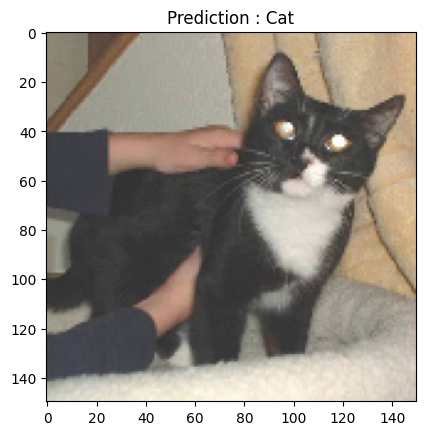

In [60]:
plt.imshow(img)
plt.title("Prediction : Dog" if pred[0][0]>0.5 else "Prediction : Cat")

### Evaluating the entire dataset

In [61]:
loss,acc  =model.evaluate(test_ds)
print("Test Loss:",loss)
print("Test accuracy:",acc)

30/30 [==============================] - 4s 117ms/step - loss: 1.2208 - accuracy: 0.7179
Test Loss: 1.2208435535430908
Test accuracy: 0.7179487347602844


In [62]:
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32")

30/30 [==============================] - 3s 106ms/step


In [67]:
# Get true labels from test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype("int32")

# Confusion Matrix
print(confusion_matrix(true_labels, predicted_labels))

# Classification Report
print(classification_report(true_labels, predicted_labels, target_names=['Cat','Dog']))

30/30 [==============================] - 3s 107ms/step
[[222 246]
 [244 224]]
              precision    recall  f1-score   support

         Cat       0.48      0.47      0.48       468
         Dog       0.48      0.48      0.48       468

    accuracy                           0.48       936
   macro avg       0.48      0.48      0.48       936
weighted avg       0.48      0.48      0.48       936



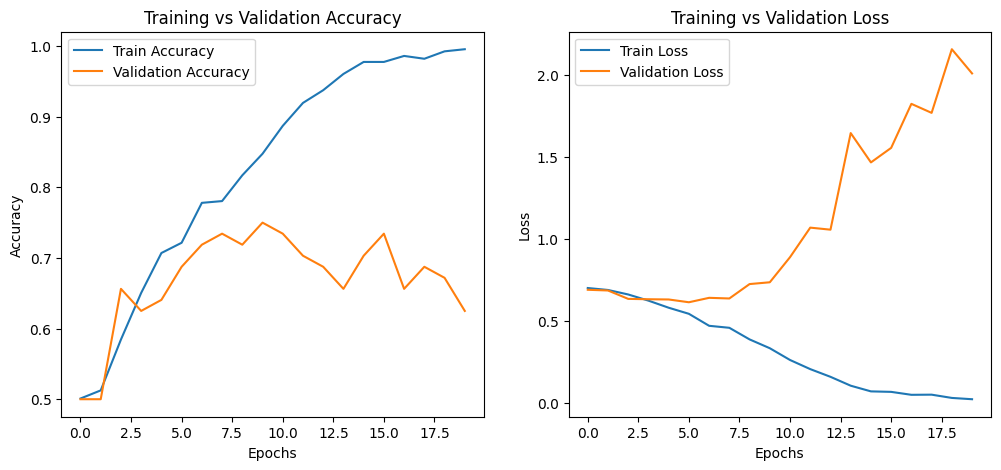

In [68]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
